In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='deep', font_scale=1.2)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Block to load file depending if you are in Colab or in Jupyter
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !nvidia-smi
    TF_CPP_MIN_LOG_LEVEL=2

    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
      raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    # get data
    !wget --no-check-certificate \
        https://www.dropbox.com/s/qbn9y5ooqxipxki/single_feature.csv?dl=0 \
        -O /tmp/Features.csv
        
    data = pd.read_csv('/tmp/Features.csv', parse_dates=['Timestamp'], index_col='Timestamp')
else:
    path_of_file = '../Data/single_feature.csv'
    data = pd.read_csv(path_of_file, parse_dates=['Timestamp'], index_col='Timestamp')


Running on CoLab
Thu Oct 29 19:39:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                       

In [ ]:
def split_sequences_multivariate(sequences, n_steps=32):
    
    '''
    Split a multivariate sequence into samples for single feature prediction
    Taken and adapted from Machinelearningmastery.
    Split the training set into segments of a specified timestep
    and creates the labels.
    '''
    #n_steps = n_steps+1
    # Place the column of the feature to predict at the end of the dataset
    #sequences = np.concatenate([X_train, X_train[:,0].reshape(-1,1)],axis=1)
    
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    
    #print(np.shape(X),np.shape(y))
    return np.array(X), np.array(y)

# split a multivariate sequence into samples
def multi_step_output(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def plot_distribution_error(model, train_X, test_X, train_y, test_y):
    train_predictions = model.predict(train_X)
    test_predictions = model.predict(test_X)

    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle('Distributions of Prediction and True Values', y=1.02, fontsize=13.5)
    sns.distplot(a=train_predictions.flatten(), ax=ax1, label='Prediction')
    sns.distplot(a=train_y.flatten(), ax=ax1, label= 'True')
    sns.distplot(a=test_predictions.flatten(), ax=ax2, label='Prediction')
    sns.distplot(a=test_y.flatten(), ax=ax2, label='True')
    plt.legend()
    plt.tight_layout()

def get_errors(model, train_X, test_X, train_y, test_y):
    
    train_predictions = model.predict(train_X)
    test_predictions = model.predict(test_X)
    
    MAE_train = abs(train_predictions - train_y).mean()
    MAE_test = abs(test_predictions - test_y).mean()
    if train_y.shape[1] == 3:
        mae_overall_train = abs(train_predictions-train_y).mean(axis=(1))
        mae_overall_test = abs(test_predictions-test_y).mean(axis=(1))
        mse_test = mean_squared_error(test_y, test_predictions)
        rmse_test = np.sqrt(mse_test)
        r2_test = r2_score(test_y, test_predictions)
    else:
        mae_overall_train = abs(train_predictions-train_y).mean(axis=(1,2))
        mae_overall_test = abs(test_predictions-test_y).mean(axis=(1,2))
        mse_test = mean_squared_error(test_y.reshape(-1,3), test_predictions.reshape(-1,3))
        r2_test = r2_score(test_y.reshape(-1,3), test_predictions.reshape(-1,3)) 

    rmse_test = np.sqrt(mse_test)
    return MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test

def plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test, suptitle):
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,4))
    fig.suptitle(suptitle, y=1.02, fontsize=16.5)
    
    ax1.plot(mae_overall_train, label='MAE Train')
    ax1.set_title('MAE Train={}'.format(MAE_train))
    ax2.plot(mae_overall_test, label='MAE Test', color='teal')
    ax2.set_title('MAE Test={}'.format(MAE_test))
    fig.legend(loc='upper right')
    plt.tight_layout()

def plot_lstm(model, X, y, feature_index=0):

    prediction = model.predict(X)
    if prediction.shape[-1] == 1:
        pred_df = pd.DataFrame(data= np.concatenate((model.predict(X), y.reshape(-1,1)), axis=1), columns=['Prediction', 'True'])
    else:
        pred_df = pd.DataFrame(data= np.concatenate((model.predict(X)[:,feature_index].reshape(-1,1),
                                                     y[:,feature_index].reshape(-1,1)), axis=1), columns=['Prediction', 'True'])
    mse = mean_squared_error(y, prediction)
    rmse = np.sqrt(mse_test)
    r2 = r2_score(y, prediction)

    fig, ax1 = plt.subplots(1,1,figsize=(14,4))
    pred_df.plot(ax=ax1)
    plt.legend(loc='upper left')
    plt.title('Prediction and Truth rmse = {}, r2 score = {}'.format(np.round(rmse,4), np.round(r2,4)))    
    plt.tight_layout()

def plot_single_seq(model, X, y, feature_index=0):

  prediction = model.predict(X)[:,7,:]
  y = y[:,7,:]
  pred_df = pd.DataFrame(data= np.column_stack((prediction.reshape(-1,3)[:,feature_index],
                                                y.reshape(-1,3)[:,feature_index])),
                          columns=['Prediction', 'True'])
    
  mse = mean_squared_error(y.reshape(-1,3), prediction.reshape(-1,3))
  rmse = np.sqrt(mse)
  r2 = r2_score(y.reshape(-1,3), prediction.reshape(-1,3)) 


  fig, ax1 = plt.subplots(1,1,figsize=(14,4))
  pred_df.plot(ax=ax1)
  plt.legend(loc='upper left')
  plt.title('Prediction and Truth rmse = {}, r2 score = {}'.format(np.round(rmse,4), np.round(r2,4)))    
  plt.tight_layout()
    
def plot_predictions(model, train_X, test_X, train_y, test_y):
    train_predictions = model.predict(train_X)
    test_predictions = model.predict(test_X)
    
    data_final = dict(train_pred=train_predictions, train_true=train_y,
                      test_pred=test_predictions, test_true=test_y)

    # Number of time steps in the future, as increases the accuracy decreases
    ith_timestep = 7

    for lb in ['train', 'test']:   
        fig, axx = plt.subplots(3,1,figsize=(18,9))
        for i, x_lbl, clr,axi in zip([0, 1, 2], ['Temperature', 'VMPPT','VPanel'], ['salmon', 'teal','darkblue'], axx):
            axi.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='-', color='r', label='pred '+x_lbl)
            axi.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
            axi.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
        fig.suptitle('({}): {}th time step in all samples'.format(lb, ith_timestep), y=1.02,fontsize=15)
        plt.tight_layout()

def train_model(model, train_X, train_y, callbacks, epochs=100, batch_size=256, patience=5, verbose=1, validation_split=0.25):

  if verbose==0:
    print('Training model')
  history = model.fit(train_X, train_y,
                      validation_split=validation_split, 
                      epochs=epochs, verbose=verbose,
                      callbacks=[callbacks], 
                      batch_size=batch_size)
  return history

class myCallback(tf.keras.callbacks.Callback):
  def __init__(self, mae=0.03):
    super(myCallback, self).__init__()
    self.mae = mae

  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_mae') <= self.mae):
      print("\nReached 0.03 mae so cancelling training!")
      self.model.stop_training = True

def forecast_att(model, train_X, train_y, forecast_range=100):

  n_timesteps_in = train_X.shape[1]
  n_timesteps_out = train_y.shape[1]
  n_features = train_X.shape[2]
  
  # first set of samples

  batch = train_X[-1, :, :]
  predictions_forecast = batch
  # future timesteps to forcast times X horizon timesteps
  for i in range(forecast_range):
    one_step_pred = model.predict(batch.reshape(1, n_timesteps_in, n_features))
    batch = np.concatenate([batch[n_timesteps_out:], one_step_pred.reshape(n_timesteps_out, n_features)], axis=0)
    predictions_forecast = np.row_stack([predictions_forecast, one_step_pred.reshape(n_timesteps_out, n_features)])

  fig, axx = plt.subplots(3, 1, figsize=(18,7))

  forecast = np.concatenate([train_y[:, n_timesteps_out-1, :], predictions_forecast], axis=0)
  forecast[:train_y.shape[0]] = None
  axx[0].plot(train_y[:, 0, 0])
  axx[0].plot(forecast[:,0])
  axx[1].plot(train_y[:, 0, 1])
  axx[1].plot(forecast[:,1])
  axx[2].plot(train_y[:, 0, 2])
  axx[2].plot(forecast[:,2])
  plt.tight_layout()

In [ ]:
### MODELS
def serialize_model(model, history, name='model'):
  '''
  Save model and history
  '''
  # serialize model to JSON
  model_json = model.to_json()
  with open(name+'.json', "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights(name+'.h5')
  history.to_csv(name+'.csv')
  print("Saved model to disk")

def load_model(name='model'):
  json_file = open(name+'.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = tf.keras.models.model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights(name+'.h5')
  print("Loaded model from disk")
  return loaded_model

def Model_recurrent(units, input_shape, dropout=0.2, LSTM=True):
  tf.keras.backend.clear_session()
  model = tf.keras.models.Sequential()

  if LSTM==False:
    model.add(tf.keras.layers.GRU(units=units, dropout=0.2, return_sequences=True, input_shape=input_shape)) 
    model.add(tf.keras.layers.GRU(units=units, input_shape=input_shape,
                                      return_sequences=False, dropout=dropout))
  else:
    model.add(tf.keras.layers.LSTM(units=units, input_shape=input_shape,
                                      return_sequences=True, dropout=dropout))
    model.add(tf.keras.layers.LSTM(units=units, return_sequences=False,
                                   dropout=dropout))
    
  #model_LSTM.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(n_features))
  return model

def Model_dnn(units, input_shape, dropout=0.2):
  tf.keras.backend.clear_session()
  model = Sequential()
  #model.add(tf.keras.layers.Reshape(input_shape, input_shape=(input_shape,)))
  model.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=input_shape))
  model.add(tf.keras.layers.Dense(units=128, activation='relu'))
  model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=input_shape[1]))
  return model

def Model_cnn(input_shape, units=128, filters=64, kernel_size=3, dropout=0.2, LSTM=False):
  tf.keras.backend.clear_session()
  model = tf.keras.models.Sequential()

  if LSTM==False:
    model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, input_shape=input_shape,
                                     activation='relu')) 
    model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
  else:
    model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, input_shape=input_shape,
                                     activation='relu'))
    model.add(tf.keras.layers.LSTM(units=units, input_shape=input_shape,
                                      return_sequences=False, dropout=dropout))
    #model.add(tf.keras.layers.LSTM(units=units, return_sequences=False,
    #                               dropout=dropout))
    
  #model_LSTM.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(n_features))
  return model

def Model_Seq(n_hidden, input_shape, output_shape, dropout):
  
  input_train = Input(shape=input_shape)
  output_train = Input(shape=output_shape)

  encoder_last_h1, encoder_last_h2, encoder_last_c = \
  tf.keras.layers.LSTM(n_hidden, activation='relu', dropout=dropout,
                       return_sequences=False,
                       return_state=True)(input_train)

  # Batch normalisation is added because we want to avoid gradient
  # explosion caused by the activation function ELU in the encoder.
  encoder_last_h1 = BatchNormalization(momentum=0.9)(encoder_last_h1)
  encoder_last_c = BatchNormalization(momentum=0.9)(encoder_last_c)

  # Create copies of las hidden state
  decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)

  # nitial_state: List of initial state tensors to be passed to the first call of the cell 
  #(optional, defaults to None which causes creation of zero-filled initial state tensors).
  # In this case initial state is the output from encoder
  decoder = tf.keras.layers.LSTM(n_hidden, activation='relu', dropout=dropout,
                                return_state=False,
                                return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

  out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
  model = tf.keras.Model(inputs=input_train, outputs=out)
  return model

Lenght of Data 14688
Lenght of Train 11750


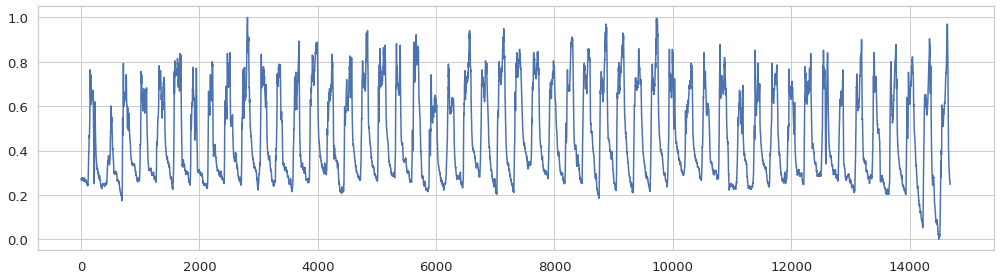

In [ ]:
# The data is higly irregular so let's resample it to 10 min and take the mean
resampled = data.resample('5Min').mean()
resampled = resampled.fillna(resampled.bfill())
# Now let's take only a slice of it

init_date = '2019-03'
train_end_date = '2019-10-25'
end_date = '2019-04-20'
#Separate Train and test
train_data = resampled[init_date:end_date]

train_ratio = 0.8
train_len = int(train_ratio*len(train_data))
scaler = MinMaxScaler()
normalized_train = scaler.fit_transform(train_data)
print('Lenght of Data {}'.format(len(normalized_train)))
print('Lenght of Train {}'.format(train_len))

fig, ax1 = plt.subplots(1,1, figsize=(14,4))
ax1.plot(normalized_train[:,0])
plt.tight_layout()

# LSTM


Training model
Mean Absolute Error in Testing  0.0663774775292527
Mean Squared Error in Testing  0.011083632174451538
R2 Score in Testing  0.8999587827633686
Root Mean Squared Error in Testing  0.10527883060925182


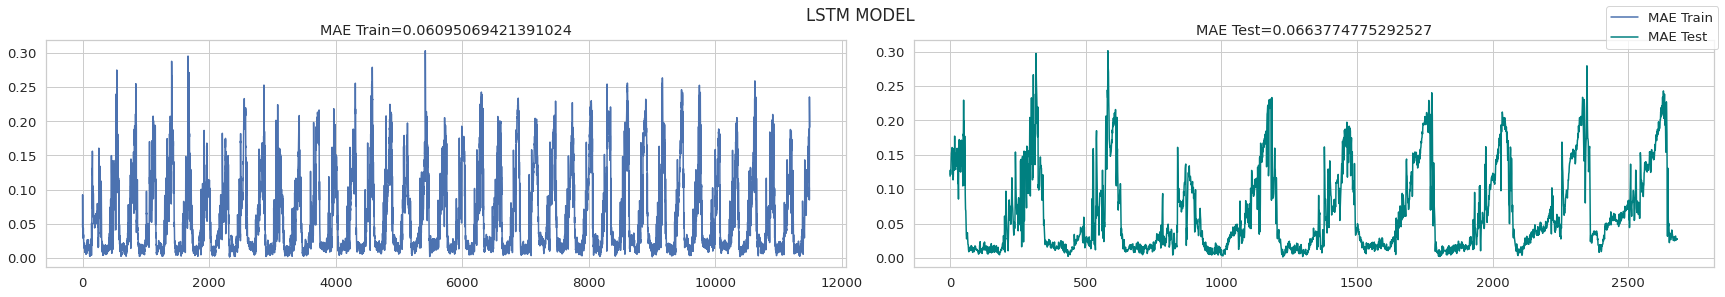

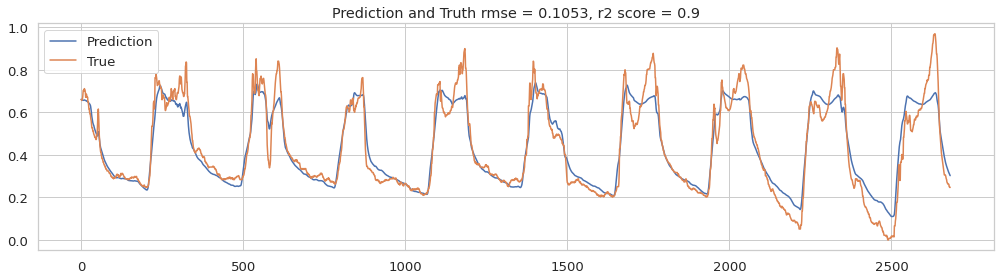

In [ ]:
n_timesteps_in = 256
n_timesteps_out = 16
n_features = 3
n_hidden = 32
epochs = 100
batch_size = 256

train_X, train_y = split_sequences_multivariate(normalized_train[:train_len], n_steps=n_timesteps_in)
test_X, test_y = split_sequences_multivariate(normalized_train[train_len:], n_steps=n_timesteps_in)

model_lstm = Model_recurrent(units=n_hidden, input_shape=(n_timesteps_in, n_features), dropout=0.3)

optimizer = tf.keras.optimizers.Adam(lr=0.01)
model_lstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history_lstm = train_model(model_lstm, train_X, train_y, callbacks=early_stop,
                           epochs=100, batch_size=256, patience=5, verbose=0)
history_lstm_df = pd.DataFrame(history_lstm.history, columns=['mae', 'val_mae'])

MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test = \
get_errors(model_lstm, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test, suptitle='LSTM MODEL')

plot_lstm(model_lstm, test_X, test_y, feature_index=0)

print('Mean Absolute Error in Testing ',MAE_test)
print('Mean Squared Error in Testing ',mse_test)
print('R2 Score in Testing ',r2_test)
print('Root Mean Squared Error in Testing ',rmse_test)

# GRU

Training model
Mean Absolute Error in Testing  0.07086746137592721
Mean Squared Error in Testing  0.011128819750151205
R2 Score in Testing  0.90376990163195
Root Mean Squared Error in Testing  0.10549322134692449


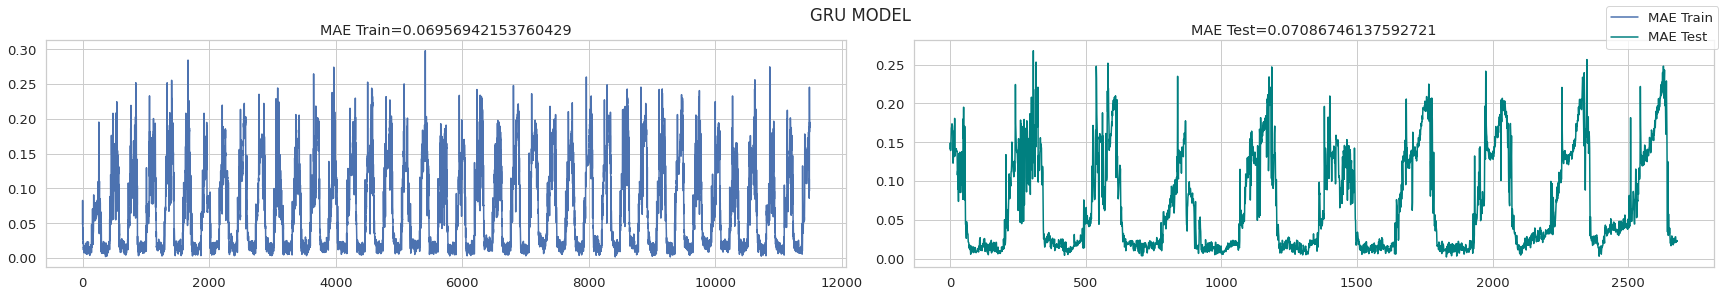

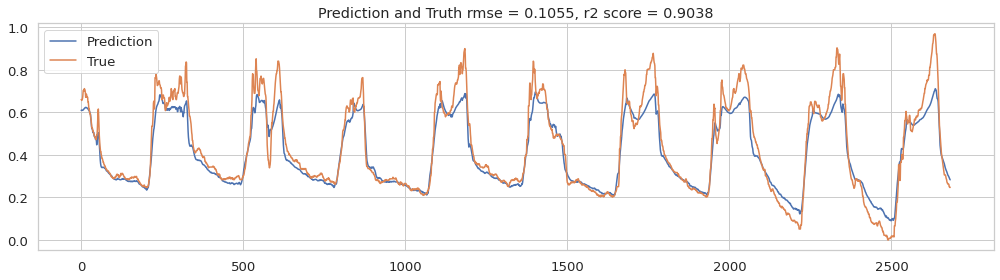

In [ ]:
n_timesteps_in = 256
n_timesteps_out = 16
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

train_X, train_y = split_sequences_multivariate(normalized_train[:train_len], n_steps=n_timesteps_in)
test_X, test_y = split_sequences_multivariate(normalized_train[train_len:], n_steps=n_timesteps_in)

model_gru = Model_recurrent(units=n_hidden, input_shape=(n_timesteps_in, n_features),
                            dropout=0.2, LSTM=False)

optimizer = tf.keras.optimizers.Adam(lr=0.01)
model_gru.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history_gru = train_model(model_gru, train_X, train_y, callbacks=early_stop,
                           epochs=100, batch_size=256, patience=5, verbose=0)
history_gru_df = pd.DataFrame(history_gru.history, columns=['mae', 'val_mae'])

MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test = \
get_errors(model_gru, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test, suptitle='GRU MODEL')

plot_lstm(model_gru, test_X, test_y, feature_index=0)

print('Mean Absolute Error in Testing ',MAE_test)
print('Mean Squared Error in Testing ',mse_test)
print('R2 Score in Testing ',r2_test)
print('Root Mean Squared Error in Testing ',rmse_test)

# CNN

Training model
Mean Absolute Error in Testing  0.08214655401187647
Mean Squared Error in Testing  0.01271824105433389
R2 Score in Testing  0.879576117699684
Root Mean Squared Error in Testing  0.11277517924762474


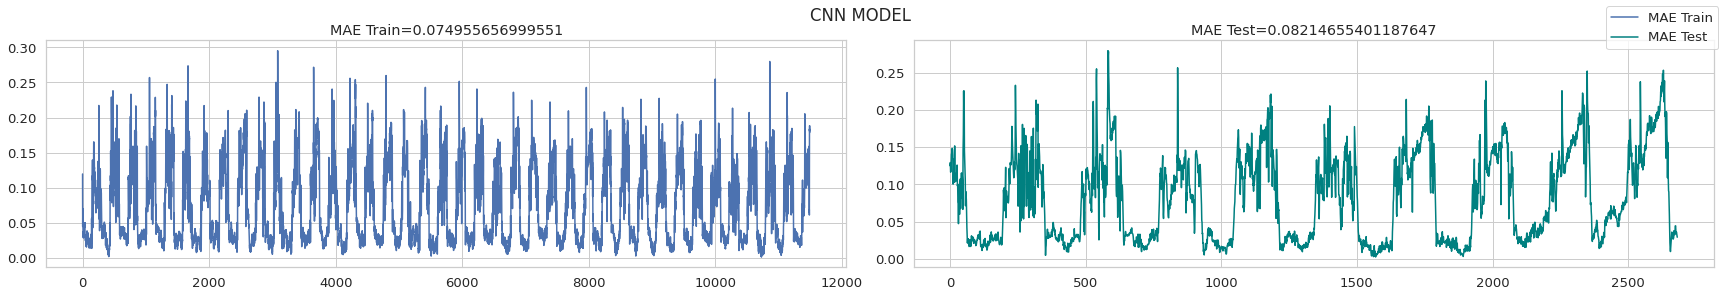

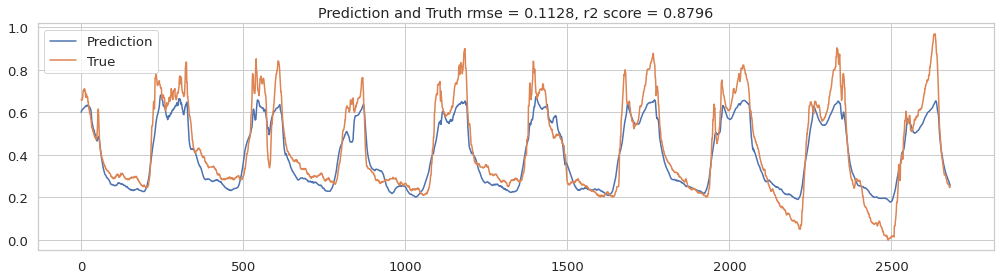

In [ ]:
n_timesteps_in = 256
n_timesteps_out = 16
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

train_X, train_y = split_sequences_multivariate(normalized_train[:train_len], n_steps=n_timesteps_in)
test_X, test_y = split_sequences_multivariate(normalized_train[train_len:], n_steps=n_timesteps_in)

model_cnn = Model_cnn(input_shape=(n_timesteps_in, n_features), filters=64,
                      kernel_size=3, dropout=0.2, LSTM=False)

optimizer = tf.keras.optimizers.Adam(lr=0.01)
model_cnn.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history_cnn = train_model(model_cnn, train_X, train_y, callbacks=early_stop,
                           epochs=100, batch_size=256, patience=5, verbose=0)
history_cnn_df = pd.DataFrame(history_cnn.history, columns=['mae', 'val_mae'])

MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test = \
get_errors(model_cnn, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test, suptitle='CNN MODEL')

plot_lstm(model_cnn, test_X, test_y, feature_index=0)

print('Mean Absolute Error in Testing ',MAE_test)
print('Mean Squared Error in Testing ',mse_test)
print('R2 Score in Testing ',r2_test)
print('Root Mean Squared Error in Testing ',rmse_test)

# DNN

Training model
Mean Absolute Error in Testing  0.09926386348790989
Mean Squared Error in Testing  0.017337963733141615
R2 Score in Testing  0.8313355116356345
Root Mean Squared Error in Testing  0.1316737017522543


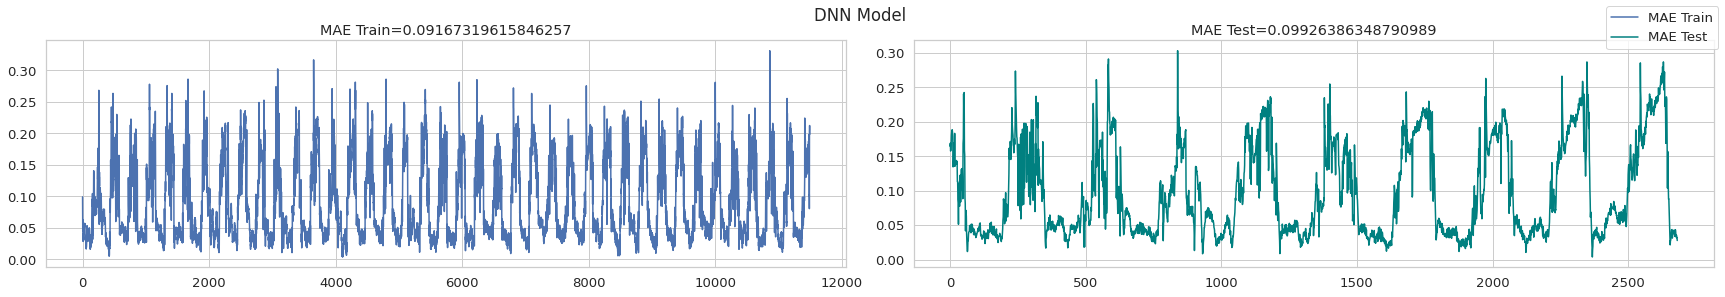

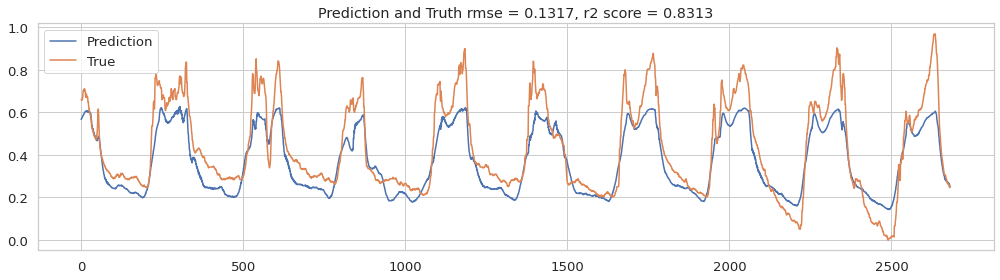

In [ ]:
n_timesteps_in = 256
n_timesteps_out = 16
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

train_X, train_y = split_sequences_multivariate(normalized_train[:train_len], n_steps=n_timesteps_in)
test_X, test_y = split_sequences_multivariate(normalized_train[train_len:], n_steps=n_timesteps_in)

model_dnn = Model_dnn(units=64, input_shape=(n_timesteps_in, n_features))

optimizer = tf.keras.optimizers.Adam(lr=0.01)
model_dnn.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history_dnn = train_model(model_dnn, train_X, train_y, callbacks=early_stop,
                           epochs=100, batch_size=256, patience=5, verbose=0)
history_dnn_df = pd.DataFrame(history_dnn.history, columns=['mae', 'val_mae'])

MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test = \
get_errors(model_dnn, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test, suptitle='DNN Model')

plot_lstm(model_dnn, test_X, test_y, feature_index=0)

print('Mean Absolute Error in Testing ',MAE_test)
print('Mean Squared Error in Testing ',mse_test)
print('R2 Score in Testing ',r2_test)
print('Root Mean Squared Error in Testing ',rmse_test)

# Seq to Seq

Epoch 1/100
34/34 [==============================] - 13s 372ms/step - loss: 2.4729 - mae: 0.3052 - val_loss: 0.1662 - val_mae: 0.3229
Epoch 2/100
34/34 [==============================] - 12s 359ms/step - loss: 0.0173 - mae: 0.0901 - val_loss: 0.0769 - val_mae: 0.2188
Epoch 3/100
34/34 [==============================] - 12s 356ms/step - loss: 0.0125 - mae: 0.0730 - val_loss: 0.0603 - val_mae: 0.1928
Epoch 4/100
34/34 [==============================] - 13s 375ms/step - loss: 0.0108 - mae: 0.0669 - val_loss: 0.0336 - val_mae: 0.1442
Epoch 5/100
34/34 [==============================] - 12s 362ms/step - loss: 0.0101 - mae: 0.0631 - val_loss: 0.0435 - val_mae: 0.1597
Epoch 6/100
34/34 [==============================] - 12s 360ms/step - loss: 0.0104 - mae: 0.0648 - val_loss: 0.0337 - val_mae: 0.1421
Epoch 7/100
34/34 [==============================] - 12s 358ms/step - loss: 0.0083 - mae: 0.0561 - val_loss: 0.0430 - val_mae: 0.1533
Mean Absolute Error in Testing  0.15265797540342377
Mean Squar

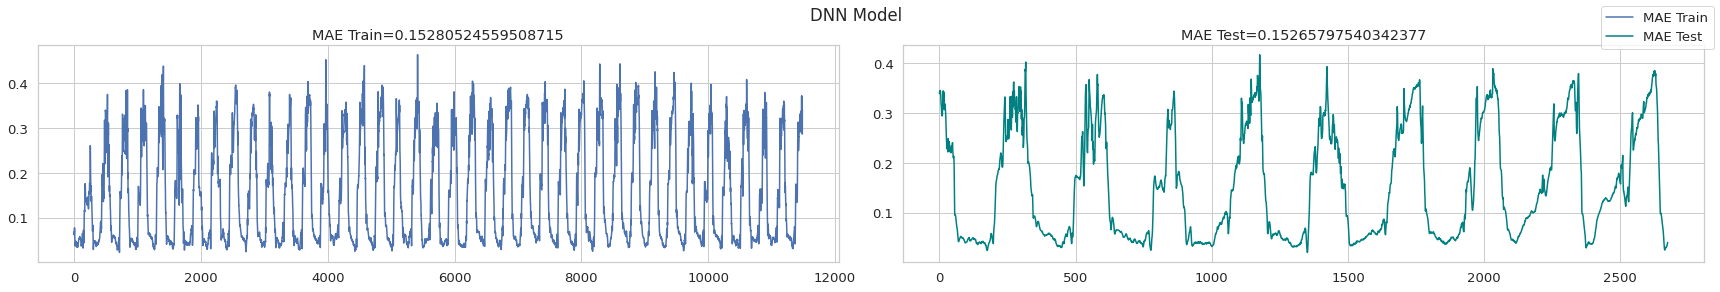

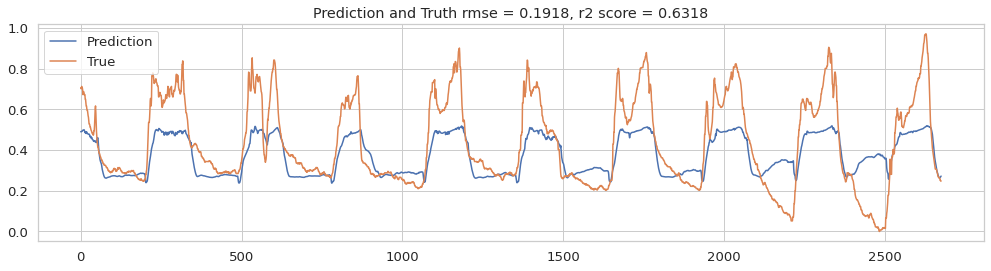

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.keras.backend.clear_session()

n_timesteps_in = 256
n_timesteps_out = 8
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)

model_seq = Model_Seq(n_hidden=128, input_shape=(n_timesteps_in, n_features),
                  output_shape=(n_timesteps_out, n_features), dropout=0.2)

optimizer = tf.keras.optimizers.Adam(lr=0.01)
model_seq.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=3)
history_seq = train_model(model_seq, train_X, train_y, callbacks=early_stop,
                          epochs=100, verbose=1)

history_seq_df = pd.DataFrame(history_seq.history, columns=['mae', 'val_mae'])

MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test = \
get_errors(model_seq, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test, suptitle='DNN Model')

plot_single_seq(model_seq, test_X, test_y)

print('Mean Absolute Error in Testing ',MAE_test)
print('Mean Squared Error in Testing ',mse_test)
print('R2 Score in Testing ',r2_test)
print('Root Mean Squared Error in Testing ',rmse_test)

# Attention

In [ ]:
def Model_Attention(n_hidden, input_shape, output_shape, dropout):

  input_train = Input(shape=input_shape)
  output_train = Input(shape=output_shape)

  encoder_stack_h, encoder_last_h, encoder_last_c = \
  tf.keras.layers.LSTM(n_hidden, activation='tanh', 
                      return_sequences=True,
                      return_state=True)(input_train)

  #encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
  #encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

  # Repeat the last hidden state of encoder 20 times, and use them as input to decoder LSTM.
  decoder_input = tf.keras.layers.RepeatVector(output_train.shape[1])(encoder_last_h)

  decoder_stack_h = tf.keras.layers.LSTM(n_hidden, activation='tanh', return_state=False,
                                        return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

  # Alignment Score is Dot Product in Luong Attention
  attention = tf.keras.layers.dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
  attention = tf.keras.layers.Activation('softmax', name='Softmax')(attention)
  context = tf.keras.layers.dot([attention, encoder_stack_h], axes=[2,1])
  #context = BatchNormalization(momentum=0.6)(context)
  # Now we concat the context vector and stacked hidden states of decoder, 
  # and use it as input to the last dense layer.
  decoder_combined_context = tf.keras.layers.concatenate([context, decoder_stack_h])
  out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(output_train.shape[2]))(decoder_combined_context)

  model = tf.keras.models.Model(inputs=input_train, outputs=out)
  
  return model

In [ ]:
n_timesteps_in = 324
n_timesteps_out = 16
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

Training model
Mean Absolute Error in Testing  0.04288266130961216
Mean Squared Error in Testing  0.006879918523559399
R2 Score in Testing  0.9358639236488333
Root Mean Squared Error in Testing  0.08294527426899859


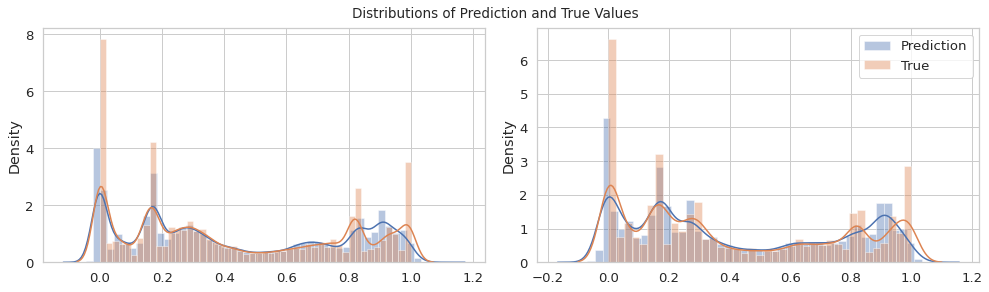

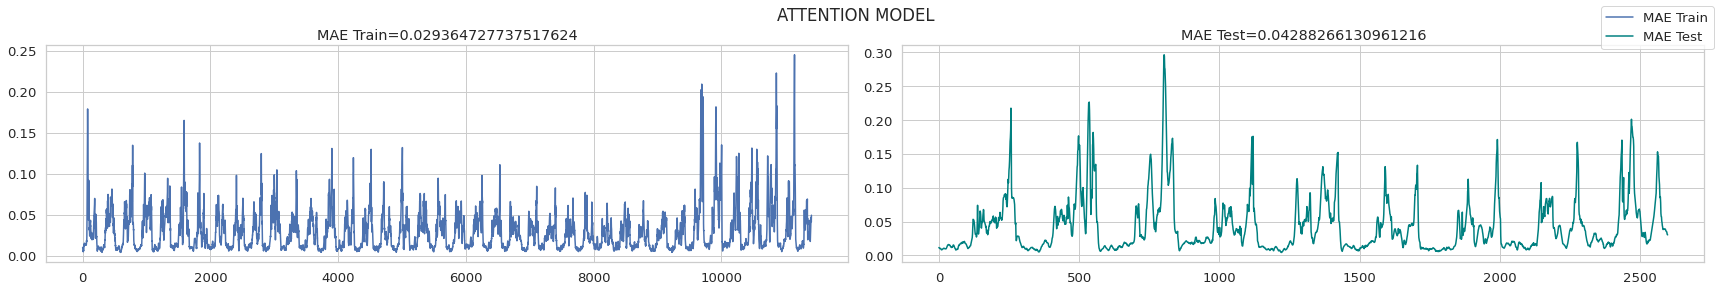

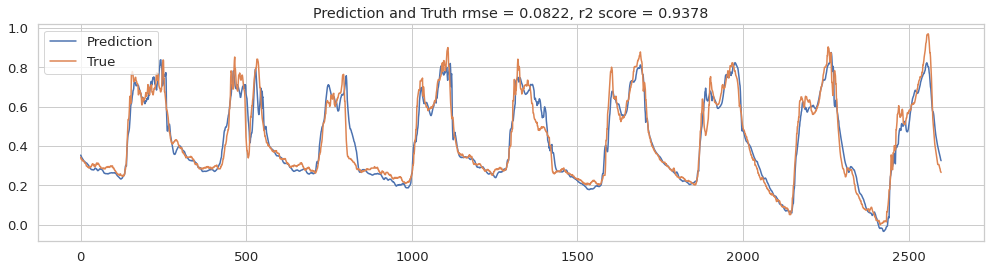

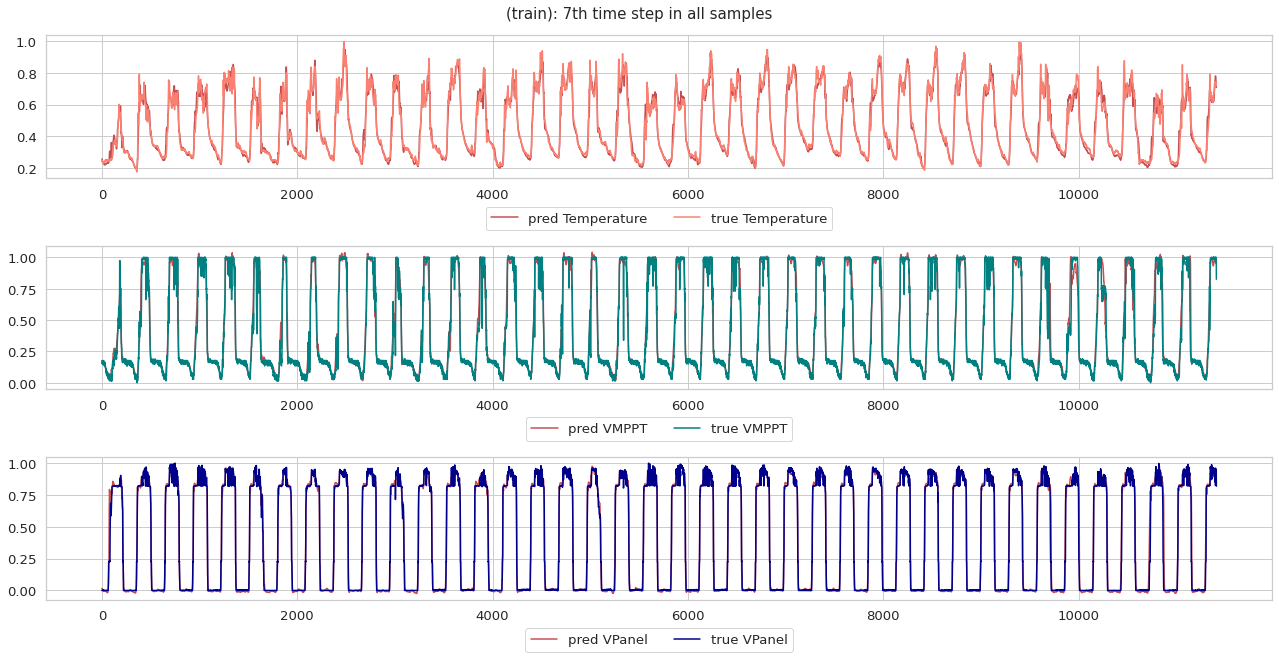

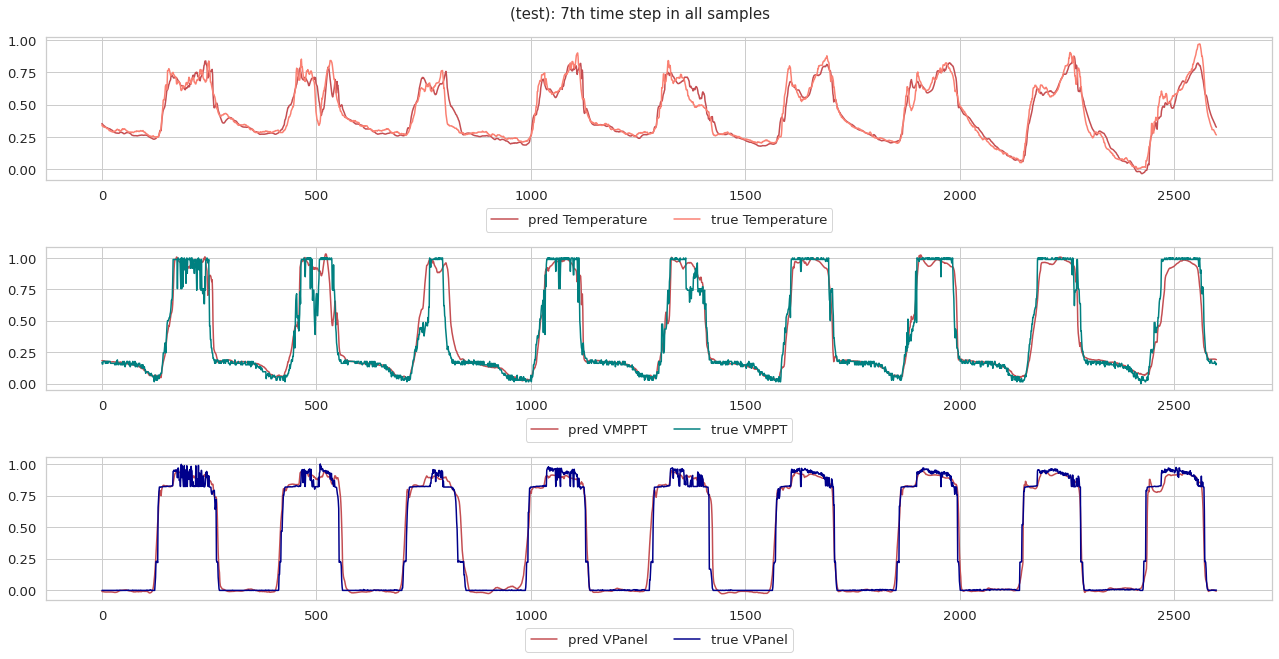

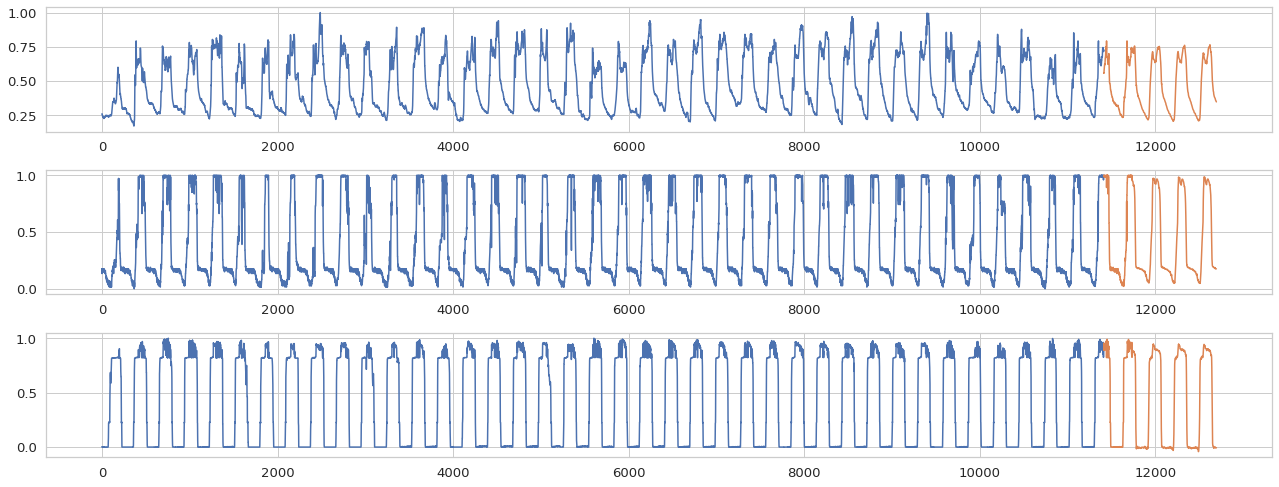

In [ ]:
tf.keras.backend.clear_session()

train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)

model_att = Model_Attention(n_hidden=n_hidden, input_shape=(n_timesteps_in, n_features),
                            output_shape=(n_timesteps_out, n_features), dropout=0.2)

optimizer = tf.keras.optimizers.Adam(lr=0.001)
model_att.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
#model.summary()

callback = myCallback(mae=0.032)
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5)

history_att = train_model(model_att, train_X, train_y, epochs=epochs,
                      batch_size=batch_size, patience=5,
                      validation_split=0.20, verbose=0,
                      callbacks=callback)

history_df = pd.DataFrame(history_att.history, columns=['mae', 'val_mae'])

plot_distribution_error(model_att, train_X, test_X, train_y, test_y)

MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test = \
get_errors(model_att, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test, suptitle='ATTENTION MODEL')
plot_single_seq(model_att, test_X, test_y)

plot_predictions(model_att, train_X, test_X, train_y, test_y)

forecast_att(model_att, train_X, train_y, forecast_range=60)

print('Mean Absolute Error in Testing ',MAE_test)
print('Mean Squared Error in Testing ',mse_test)
print('R2 Score in Testing ',r2_test)
print('Root Mean Squared Error in Testing ',rmse_test)

In [ ]:
#serialize_model(model_att, history=history_df, name='model_att_forecast')

# Overfitted Attention


In [ ]:
tf.keras.backend.clear_session()

n_timesteps_in = 256
n_timesteps_out = 8
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)

model_att = Model_Attention(n_hidden=n_hidden, input_shape=(n_timesteps_in, n_features),
                            output_shape=(n_timesteps_out, n_features), dropout=0.2)

optimizer = tf.keras.optimizers.Adam(lr=0.001)
model_att.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
#model.summary()

callback = myCallback(mae=0.030)
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5)

history_att = train_model(model_att, train_X, train_y, epochs=epochs,
                      batch_size=batch_size, patience=5,
                      validation_split=0.20, verbose=0,
                      callbacks=callback)

history_df = pd.DataFrame(history_att.history, columns=['mae', 'val_mae'])

MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test = \
get_errors(model_att, train_X, test_X, train_y, test_y)

print('Mean Absolute Error in Testing ',MAE_test)
print('Mean Squared Error in Testing ',mse_test)
print('R2 Score in Testing ',r2_test)
print('Root Mean Squared Error in Testing ',rmse_test)

Training model
Mean Absolute Error in Testing  0.018607266138385835
Mean Squared Error in Testing  0.00144167992556532
R2 Score in Testing  0.9896467627180318
Root Mean Squared Error in Testing  0.03796946043289686


# Comparing Models

In [ ]:
n_timesteps_in = 256
n_timesteps_out = 8
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

feature_index = 0

# Baseline models
train_X, train_y = split_sequences_multivariate(normalized_train[:train_len], n_steps=n_timesteps_in)
test_X, test_y = split_sequences_multivariate(normalized_train[train_len:], n_steps=n_timesteps_in)

prediction_lstm = model_lstm.predict(test_X)
prediction_gru = model_gru.predict(test_X)
prediction_cnn = model_cnn.predict(test_X)

data = np.column_stack([prediction_lstm[:,feature_index],
                       prediction_gru[:,feature_index],
                       prediction_cnn[:,feature_index]])
## Sequences models
train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)

prediction_seq = model_seq.predict(test_X)[:,7,:]
prediction_att = model_att.predict(test_X)[:,7,:]

data = data[:prediction_att.reshape(-1,3).shape[0]]
data_seq = np.column_stack([data, prediction_seq.reshape(-1,3)[:,feature_index],
                           prediction_att.reshape(-1,3)[:,feature_index],
                            test_y[:,7,:].reshape(-1,3)[:,feature_index]])

In [ ]:
predictions_df = pd.DataFrame(data=data_seq, columns=['LSTM','GRU', 'CNN', 'Seq2Seq','Attention','Real_Values'])

In [ ]:
predictions_df = predictions_df.set_index(train_data[train_len:].index[-predictions_df.shape[0]:])

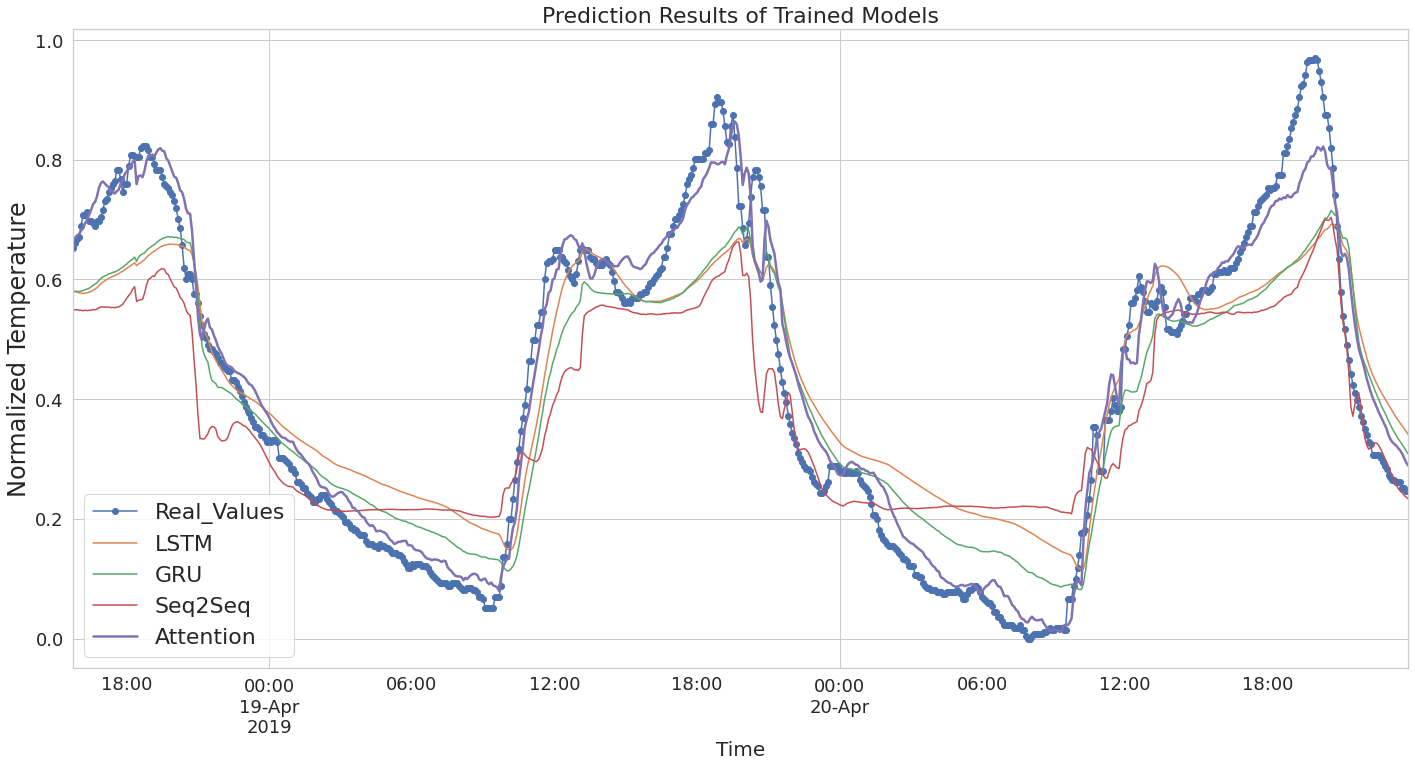

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(20, 11))
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)

predictions_df[2000:]['Real_Values'].plot(ax=ax1, marker='o')
predictions_df[2000:]['LSTM'].plot(ax=ax1)
predictions_df[2000:]['GRU'].plot(ax=ax1)
predictions_df[2000:]['Seq2Seq'].plot(ax=ax1)
predictions_df[2000:]['Attention'].plot(ax=ax1, linewidth=2.5)
plt.title(label='Prediction Results of Trained Models', fontsize=22)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Normalized Temperature', fontsize=24)
plt.legend(fontsize=22)
plt.tight_layout()

In [ ]:
fig.savefig('Comparison_2.pdf', bbox_inches='tight')

# Load saved model

Run this cell if you want to load a model and skip train

In [ ]:
# get forecast model model
!wget --no-check-certificate \
    https://www.dropbox.com/s/o45us0s57bgm4xn/model_att_forecast.h5?dl=0 \
    -O /tmp/model_att_forecast.h5
!wget --no-check-certificate \
    https://www.dropbox.com/s/eraffylxnpwljb3/model_att_forecast.json?dl=0 \
    -O /tmp/model_att_forecast.json
!wget --no-check-certificate \
    https://www.dropbox.com/s/9l2331jysaj2i6g/model_att_forecast.csv?dl=0 \
    -O /tmp/model_att_forecast.csv

# get prediction model

!wget --no-check-certificate \
    https://www.dropbox.com/s/vc3o4g84pf6kjlk/overfitted_att.h5?dl=0 \
    -O /tmp/overfitted_att.h5
!wget --no-check-certificate \
    https://www.dropbox.com/s/4bjy9bcuri9c1l2/overfitted_att.json?dl=0 \
    -O /tmp/overfitted_att.json
!wget --no-check-certificate \
    https://www.dropbox.com/s/x2mc3mghz291t8a/overfitted_att.csv?dl=0 \
    -O /tmp/overfitted_att.csv

# Plot Forecast

In [ ]:
# Loaded model is trained for 324 input sequences
model_att = load_model(name='/tmp/model_att_forecast')

n_timesteps_in = 324
n_timesteps_out = 16
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)

Loaded model from disk


In [ ]:
expanded_end_date = '2019-04-14'

expanded_train=resampled[init_date : expanded_end_date]
expanded_train=scaler.transform(expanded_train)

# first set of samples
forecast_range=10
palette = sns.color_palette('deep')

batch = train_X[-1, :, :]
predictions_forecast = train_X[-1, :, :]
# future timesteps to forcast times X horizon timesteps
for i in range(forecast_range):
  one_step_pred = model_att.predict(batch.reshape(1, n_timesteps_in, n_features))
  batch = np.row_stack([batch[n_timesteps_out:], one_step_pred.reshape(n_timesteps_out, n_features)])
  predictions_forecast = np.row_stack([predictions_forecast, one_step_pred.reshape(n_timesteps_out, n_features)])

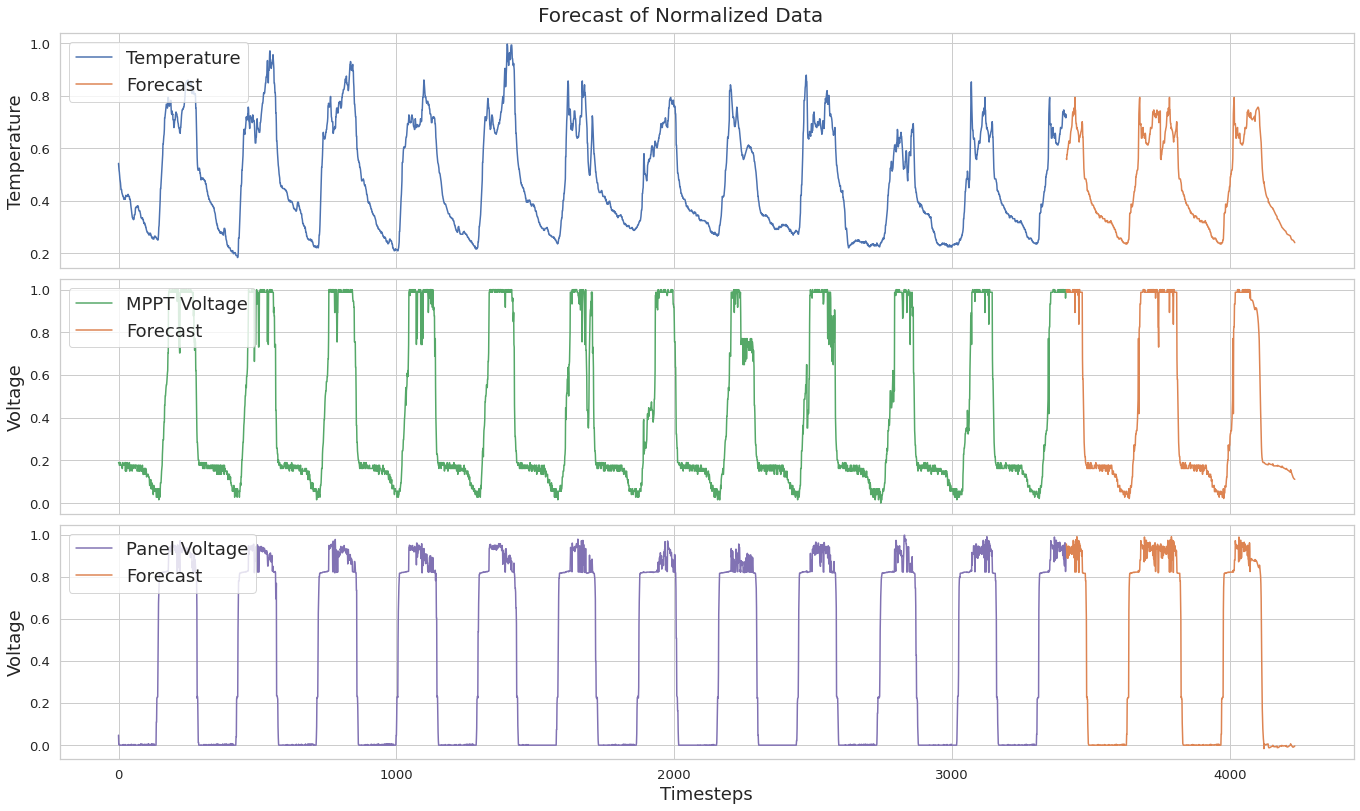

In [ ]:
fig, axx = plt.subplots(3, 1, figsize=(19,11), sharex=True)

fig.suptitle('Forecast of Normalized Data',y=1.02, fontsize=20)
forecast = np.concatenate([normalized_train[:train_len], predictions_forecast], axis=0)
forecast[:train_y.shape[0]] = None
axx[0].plot(train_y[:, 0, 0][8000:], color=palette[0], label='Temperature')
axx[0].plot(forecast[:,0][8000:], color=palette[1], label='Forecast')
axx[0].set_ylabel('Temperature', fontsize=18); axx[0].legend(loc='upper left', fontsize=18)

axx[1].plot(train_y[:, 0, 1][8000:], color=palette[2], label='MPPT Voltage')
axx[1].plot(forecast[:,1][8000:], color=palette[1], label='Forecast')
axx[1].set_ylabel('Voltage', fontsize=18); axx[1].legend(loc='upper left', fontsize=18)

axx[2].plot(train_y[:, 0, 2][8000:], color=palette[4], label='Panel Voltage')
axx[2].plot(forecast[:,2][8000:], color=palette[1], label='Forecast')
axx[2].set_ylabel('Voltage', fontsize=18); axx[2].legend(loc='upper left', fontsize=18)
axx[2].set_xlabel('Timesteps', fontsize=18)
plt.tight_layout()
fig.savefig('Forecast.pdf', bbox_inches='tight')

# Comparing errors for transmisions

In [ ]:
#------- Run this to skip training again-------------
# Loading model

n_timesteps_in = 256
n_timesteps_out = 8
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

model_att = load_model(name='/tmp/overfitted_att')

train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)

Loaded model from disk


In [ ]:
# get the errors
k = 2
_, _, mae_overall_train, _, _, _, _ = get_errors(model_att, train_X, test_X, train_y, test_y)
quartiles = np.percentile(mae_overall_train, [25, 50, 75])
data_min, data_max = mae_overall_train.min(), mae_overall_train.max()
print('Q3: %.3f' % quartiles[2])

threshold = quartiles[2]*k
print('threshold ',threshold)

Q3: 0.038
threshold  0.07592269870645917


## Taking entire Batch

In this case we transmit the batch of predicted values

In [ ]:
# next_bath starts with the last batch of the training set
next_batch = train_X[-1, :, :]
predictions_forecast = []
next_step_truth_list = []
counter = 0
error_stack = []

# Repeat a number of future timesteps
for ii in range(100):
  # Reshape to 3D for prediction
  next_step_pred = model_att.predict(next_batch.reshape(1, n_timesteps_in, n_features))
  # Reshape to 2D
  next_step_pred = next_step_pred.reshape(n_timesteps_out, n_features)

  # the real values are in normalized_train. Starting from train_len is the testing data set
  # which is the continuation (or truth) of the values predicted in from the last training batch
  # but only n_timesteps_out amounth. We have to shift the timesteps in validation by n_timesteps_out times 
  next_step_truth = normalized_train[train_len:][ii * n_timesteps_out : n_timesteps_out*(ii+1)]
  next_step_truth_list.append(next_step_truth)
  # calculate error
  error_temp = abs(next_step_truth[:,0] - next_step_pred[:,0])
  error_vmppt = abs(next_step_truth[:,1] - next_step_pred[:,1])
  error_vpanel = abs(next_step_truth[:,2] - next_step_pred[:,2])
  error = abs(next_step_truth - next_step_pred).mean()

  # Stack the rolling MAE for counting the points
  # Next we have to ensamble the data with the points and 
  # not with the sequences but for now let's just count
  error_temp = error_temp.reshape(-1,1).mean(axis=1)
  error_stack.append(error_temp)

  if error > 0.05:
    # Save the predicted values
    predictions_forecast.append(next_step_truth)
    # Take the next batch for predcition
    next_batch = np.row_stack([next_batch[n_timesteps_out:], next_step_truth])
    counter+=1
  else:
    # Save the predicted values
    predictions_forecast.append(next_step_pred)
    # Take the next batch for predcition
    next_batch = np.row_stack([next_batch[n_timesteps_out:], next_step_pred])

    #print('MAE Temp {}, MAE VMPPT {}, MAE VPAN {}, MAE {}'.format(error_temp, error_vmppt, error_vpanel, error))  

Number of Sequences to transmit  30


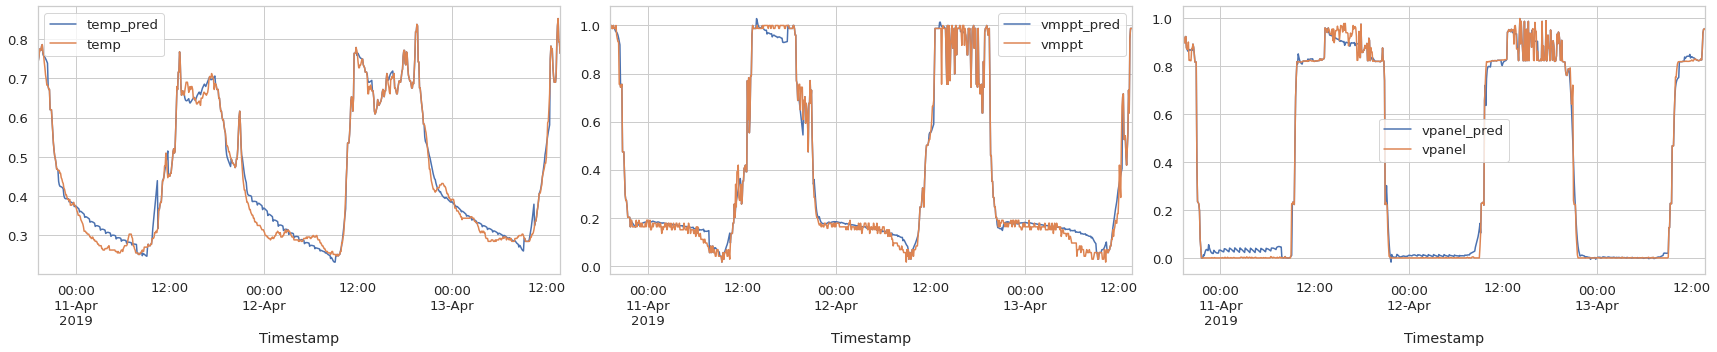

In [ ]:
#--------------- this part is for plotting and create dataframes----------------------

print('Number of Sequences to transmit ',counter)

# reshape predictions
predictions_forecast = np.array(predictions_forecast).reshape(-1,3)
# reshape real values
forecast_truth = np.array(next_step_truth_list).reshape(-1,3)
# Stack error and real values
error_forecast = np.column_stack([predictions_forecast,forecast_truth])
# create dataframe with truth and error
error_forecast_df = pd.DataFrame(data=error_forecast, columns=['temp_pred','vmppt_pred','vpanel_pred','temp','vmppt','vpanel'])
# Set date index for dataframe taking
error_forecast_df = error_forecast_df.set_index(train_data[train_len:][:error_forecast_df.shape[0]].index)

# Create dataframe of errors > threshold
# error stack is the MAE calculated above and stacked
err = np.array(error_stack).reshape(-1,1)
err_df = pd.DataFrame(err, columns=['error'])
err_df = err_df.loc[err_df['error']>0.05]

fig, axx = plt.subplots(1, 3, figsize=(24,5))
error_forecast_df[['temp_pred','temp']].plot(ax=axx[0])
error_forecast_df[['vmppt_pred','vmppt']].plot(ax=axx[1])
error_forecast_df[['vpanel_pred','vpanel']].plot(ax=axx[2])
plt.tight_layout()

# Taking point by point

In this case we transmit the different points only, not the entire batch

In [ ]:
def forecast_for_tx(model, train_X, normalized_train, n_timesteps_out, pred_range=100, threshold=0.08):
  '''
  Function to make a forecast checking the error in prediction.
  If the error is too big, then the real values are copied t the prediction
  so next prediction will consider real points. This will diminish the error in
  forecast. Considering only error in temperature to make it simple.
  '''
  n_timesteps_in = train_X.shape[1]
  n_features = train_X.shape[-1]
  
  # next_bath starts with the last batch of the training set
  next_batch = train_X[-1, :, :]
  predictions_forecast = []
  next_step_truth_list = []
  counter = 0
  error_stack = []

  # Repeat a number of future timesteps
  for ii in range(pred_range):
    # Reshape to 3D for prediction
    next_step_pred = model.predict(next_batch.reshape(1, n_timesteps_in, n_features))
    # Reshape to 2D
    next_step_pred = next_step_pred.reshape(n_timesteps_out, n_features)

    # the real values are in normalized_train. Starting from train_len is the testing data set
    # which is the continuation (or truth) of the values predicted in from the last training batch
    # but only n_timesteps_out amounth. We have to shift the timesteps in validation by n_timesteps_out times 
    next_step_truth = normalized_train[train_len:][ii * n_timesteps_out : n_timesteps_out*(ii+1)]
    next_step_truth_list.append(next_step_truth)
    # calculate error
    error_temp = abs(next_step_truth[:,0] - next_step_pred[:,0])
    error_vmppt = abs(next_step_truth[:,1] - next_step_pred[:,1])
    error_vpanel = abs(next_step_truth[:,2] - next_step_pred[:,2])
    error = abs(next_step_truth - next_step_pred).mean()

    # Stack the rolling MAE for counting the points
    # Next we have to ensamble the data with the points and 
    # not with the sequences but for now let's just count
    error_temp = error_temp.reshape(-1,1).mean(axis=1)
    error_stack.append(error_temp)

    #transmitting points with higher error
    prep_batch = next_step_pred
    for elem in range(len(error_temp)):
      if error_temp[elem] > threshold:
        prep_batch[elem] = next_step_truth[elem]
        counter+=1

    predictions_forecast.append(prep_batch)
    # Take the next batch for predcition
    next_batch = np.row_stack([next_batch[n_timesteps_out:], prep_batch])

  # convert to numpy & reshape predictions
  predictions_forecast = np.array(predictions_forecast).reshape(-1,3)
  # convert to numpy & reshape real values
  forecast_truth = np.array(next_step_truth_list).reshape(-1,3)
  # Stack error and real values
  forecast_result = np.column_stack([predictions_forecast,forecast_truth])

  return error_stack, forecast_result, counter

Number of Points to transmit  30
Percent of Points transmitted  7.25


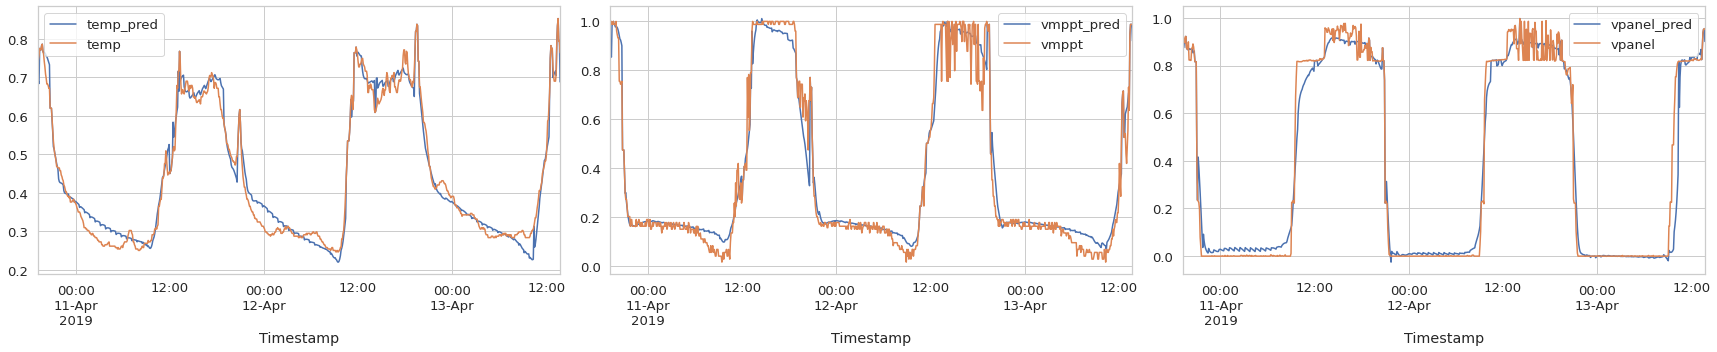

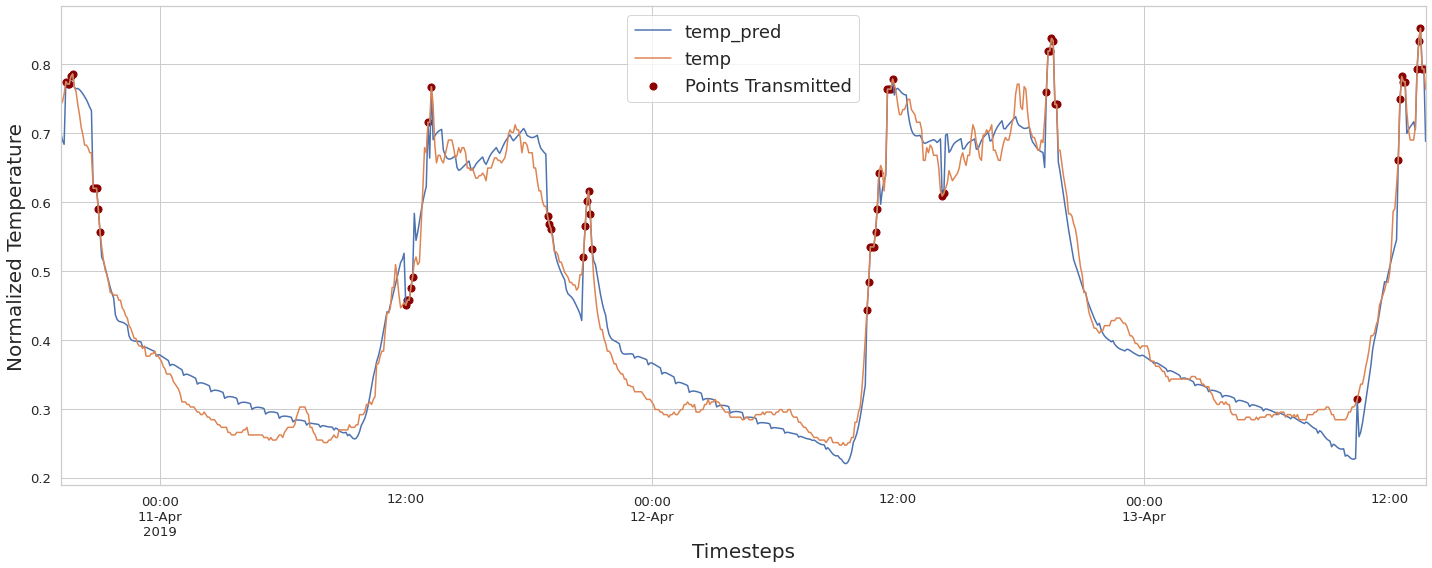

In [ ]:
print('Number of Points to transmit ',counter)
error_stack, forecast_result, counter = forecast_for_tx(model_att, train_X, normalized_train, n_timesteps_out)

# create dataframe with truth and error
forecast_result_df = pd.DataFrame(data=forecast_result, columns=['temp_pred','vmppt_pred','vpanel_pred','temp','vmppt','vpanel'])
# Set date index for dataframe taking
forecast_result_df = forecast_result_df.set_index(train_data[train_len:][:forecast_result_df.shape[0]].index)
# error stack only contains temperature error
err = np.array(error_stack).reshape(-1,1)

fig, axx = plt.subplots(1, 3, figsize=(24,5))
forecast_result_df[['temp_pred','temp']].plot(ax=axx[0])
forecast_result_df[['vmppt_pred','vmppt']].plot(ax=axx[1])
forecast_result_df[['vpanel_pred','vpanel']].plot(ax=axx[2])
plt.tight_layout()

# add the error to the dataframe to plot the points
forecast_result_df['error'] = err
# compare with a threshold
forecast_result_df['Transmitted'] = (forecast_result_df['error'] > 0.08)
# create dataframe that contains points to be transmitted
points_tx = pd.DataFrame(data = forecast_result_df[forecast_result_df['Transmitted']==True]['temp'], index=forecast_result_df[forecast_result_df['Transmitted']==True].index)
# Plot
fig, ax1 = plt.subplots(1, 1, figsize=(20,8))
forecast_result_df[['temp_pred','temp']].plot(ax=ax1)
ax1.scatter(x=points_tx.index, y=points_tx['temp'],
                    color='darkred', label='Points Transmitted', s=50)
plt.xlabel('Timesteps', fontsize=20, y=1.03)
plt.ylabel('Normalized Temperature', fontsize=20)
plt.legend(fontsize=18)
plt.tight_layout()
plt.tight_layout()

print('Percent of Points transmitted ',(counter*100)/800)

# Checking multiple thresholds

Unnormalized

In [ ]:
count_list = []
percent_list=[]
error_list = []
std_list = []
rolling_mae = []
for ii in np.linspace(0.020, 0.15, 50):
  error_stack, forecast_result, counter = forecast_for_tx(model_att, train_X, normalized_train, n_timesteps_out, threshold=ii)
  count_list.append(counter)
  percent_list.append((counter*100)/800)
  error_list.append(abs(forecast_result[:,0] - forecast_result[:,3]).mean() * 43.5)
  std_list.append(abs(forecast_result[:,0] - forecast_result[:,3]).std())
  rolling_mae.append(abs(forecast_result[:,0] - forecast_result[:,3]).reshape(-1,1).mean(axis=1))

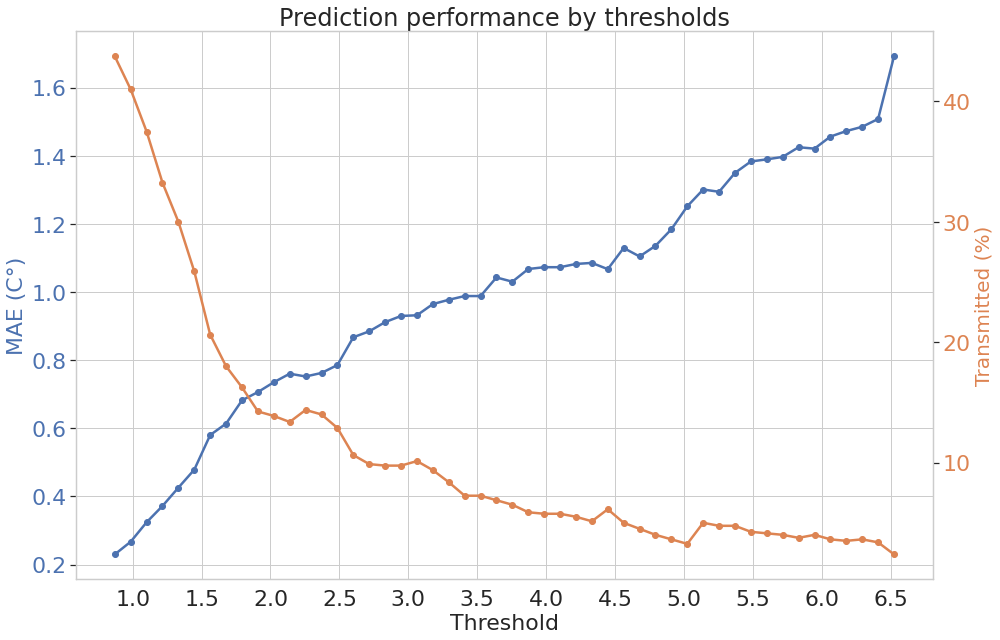

In [ ]:
bars = False
fig, ax1 = plt.subplots(1,1, figsize=(14,9))
if bars==True:
  ax1.errorbar(np.linspace(0.020, 0.15, 50)*43.5, np.array(error_list),yerr=np.array(std_list)*43.5, linewidth=2.5, fmt='-o',)
else:
  ax1.plot(np.linspace(0.020, 0.15, 50)*43.5, np.array(error_list), linewidth=2.5, marker='o')
  ax1.set_title('Prediction performance by thresholds', fontsize=24)
  ax1.set_ylabel('MAE (C\N{DEGREE SIGN})', fontsize=22, color=sns.color_palette('deep')[0])
  ax1.set_xlabel('Threshold', fontsize=22)
  ax1.xaxis.set_tick_params(labelsize=22)
  ax1.yaxis.set_tick_params(labelsize=22, labelcolor=sns.color_palette('deep')[0])
  ax1.set_xticks(np.arange(0.5, 7, 0.5))

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  ax2.plot(np.linspace(0.020, 0.15, 50)*43.5, percent_list, color=sns.color_palette('deep')[1], linewidth=2.5, marker='o')
  ax2.set_xlabel('Threshold \n b)', fontsize=20)
  ax2.set_ylabel('Transmitted (%)', fontsize=20, color=sns.color_palette('deep')[1])
  ax2.grid(b=False)
  ax2.xaxis.set_tick_params(labelsize=22)
  ax2.yaxis.set_tick_params(labelsize=22, labelcolor=sns.color_palette('deep')[1])
  plt.tight_layout()

  fig.savefig('Thresholds_sweep.pdf', bbox_inches='tight')

In [ ]:
# Comparing two forecast
# Threshols = 0.03, 0.07
error_stack, forecast_result, counter = forecast_for_tx(model_att, train_X, normalized_train, n_timesteps_out, threshold=0.02)
forecast_result_df = pd.DataFrame(data=forecast_result, columns=['temp_pred','vmppt_pred','vpanel_pred','temp','vmppt','vpanel'])
forecast_result_df = forecast_result_df.set_index(train_data[train_len:][:forecast_result_df.shape[0]].index)
# Threshols = 0.08
error_stack_2, forecast_result_2, counter_2 = forecast_for_tx(model_att, train_X, normalized_train, n_timesteps_out, threshold=0.057)
forecast_result_df_2 = pd.DataFrame(data=forecast_result_2, columns=['temp_pred','vmppt_pred','vpanel_pred','temp','vmppt','vpanel'])
forecast_result_df_2 = forecast_result_df_2.set_index(train_data[train_len:][:forecast_result_df_2.shape[0]].index)
print(counter)
print(counter_2)

395
105


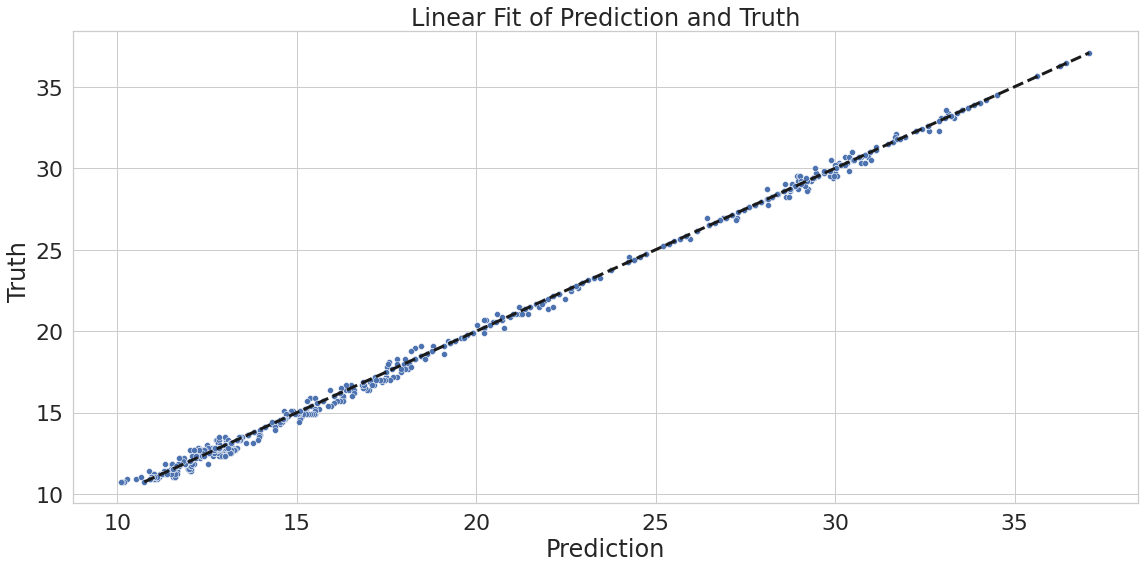

In [ ]:
# Need to convert the list to numpy array and reshape to column form
x = np.array(forecast_result[:,0]).reshape(-1,1)
y = np.array(forecast_result[:,3]).reshape(-1,1)

# Scatter between prediction and real data to check accuracy
fig, ax1 = plt.subplots(1,1,figsize=(16,8))
sns.scatterplot(x=forecast_result[:,0]*43.5, y=forecast_result[:,3]*43.5, ax=ax1)
ax1.plot([y.min()*43.5, y.max()*43.5], [y.min()*43.5, y.max()*43.5], 'k--', lw=3)
ax1.set_title(label='Linear Fit of Prediction and Truth', fontsize=24)
ax1.set_xlabel('Prediction', fontsize=24)
ax1.set_ylabel('Truth ', fontsize=24)
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
plt.tight_layout()

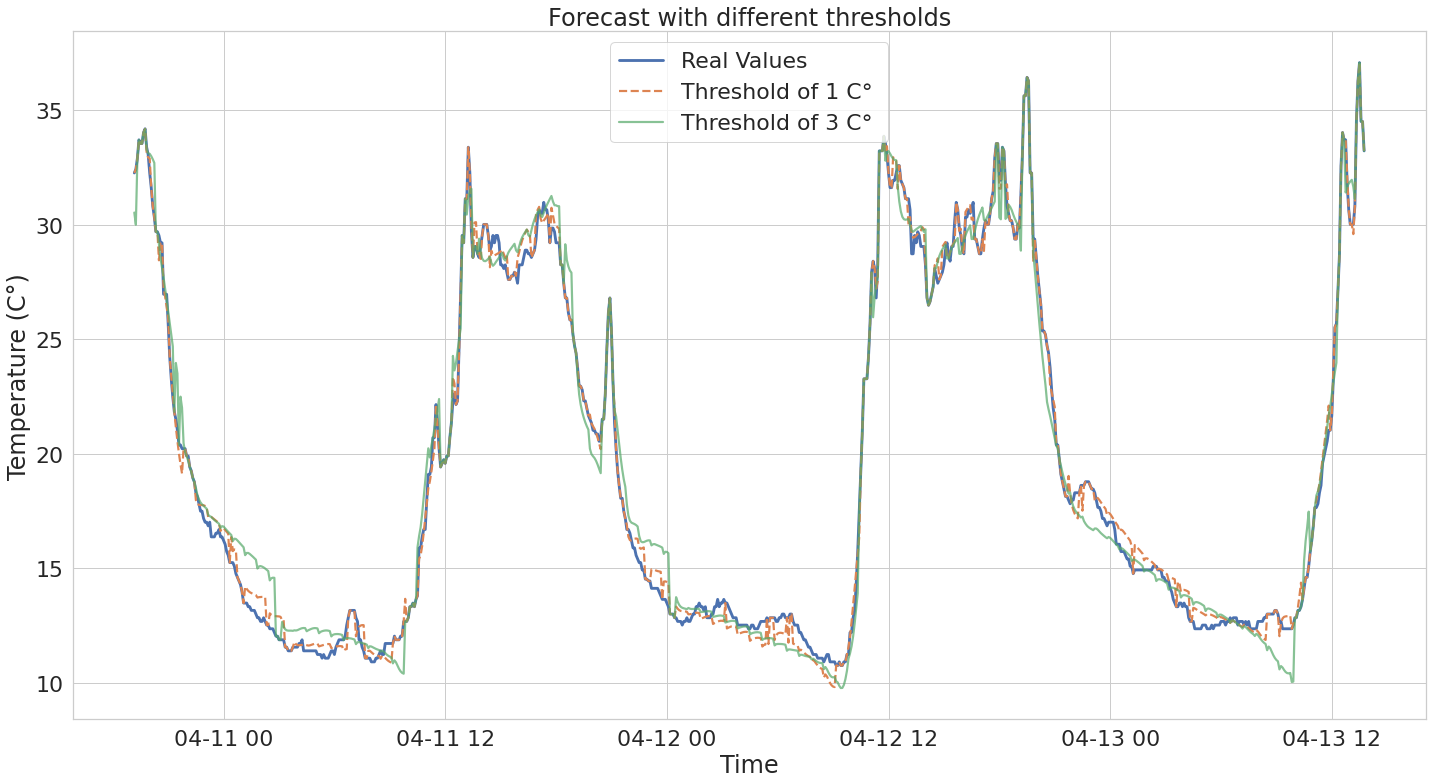

In [ ]:
fig, axx = plt.subplots(1, 1, figsize=(20,11))
# Multiplying by Max value of temperature
axx.plot(forecast_result_df['temp']*43.5, label = 'Real Values', linewidth=2.85)
axx.plot(forecast_result_df[['temp_pred']]*43.5, label='Threshold of 1 C\N{DEGREE SIGN} ', linewidth=2.2, linestyle='--')
axx.plot(forecast_result_df_2[['temp_pred']]*43.5, label = 'Threshold of 3 C\N{DEGREE SIGN}', linewidth=2.2,alpha=0.7)
plt.title(label='Forecast with different thresholds', fontsize=24)
plt.xlabel('Time', fontsize=24)
plt.ylabel('Temperature (C\N{DEGREE SIGN})', fontsize=24)
axx.xaxis.set_tick_params(labelsize=22)
axx.yaxis.set_tick_params(labelsize=22)
plt.legend(fontsize=22, loc='upper center')
plt.tight_layout()
fig.savefig('Compare_thresholds.pdf', bbox_inches='tight')

# Anomaly detections for fun

Thus is another thing totally different


In [ ]:
def anomalies(predictions_df, model, model_label='Attention', k=3, plot=True):

  _, _, mae_overall_train, _, _, _, _ = get_errors(model, train_X, test_X, train_y, test_y)
  quartiles = np.percentile(mae_overall_train, [25, 50, 75])
  data_min, data_max = mae_overall_train.min(), mae_overall_train.max()
  print('Q3: %.3f' % quartiles[2])

  threshold = quartiles[2]*k

  MAE_df = pd.DataFrame(data=abs(predictions_df[['Real_Values']].values - predictions_df[[model_label]].values).mean(axis=1), columns=['MAE'], index=predictions_df.index)

  MAE_df['Transmitted'] = (MAE_df['MAE'] > threshold)
  percent_transmitted = (MAE_df['Transmitted'].sum()/MAE_df.shape[0])*100
  print('Percent Transmitted = {} with {} model and k = {}'.format(percent_transmitted, model_label, k))

  anomalies = pd.DataFrame(data = predictions_df.loc[MAE_df[MAE_df['Transmitted']==True].index]['Real_Values'], index=MAE_df[MAE_df['Transmitted']==True].index)
  
  if plot==True:
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 10))

    predictions_df[model_label]['2019-04-18':].plot(ax=ax1, label='Prediction')
    predictions_df['Real_Values']['2019-04-18':].plot(ax=ax1)
    ax1.scatter(x=anomalies['2019-04-18':].index, y=anomalies['2019-04-18':]['Real_Values'],
                    color='darkred', label='Outlier', s=50)
    plt.title(label='Data to be transmitted in Testing Dataset', fontsize=22, y=1.03)
    plt.xlabel('Timesteps', fontsize=20, y=1.03)
    plt.ylabel('Normalized Temperature', fontsize=20)
    plt.legend(fontsize=18)
    plt.tight_layout()

  return MAE_df

Q3: 0.038
Percent Transmitted = 6.130841121495327 with Attention model and k = 3


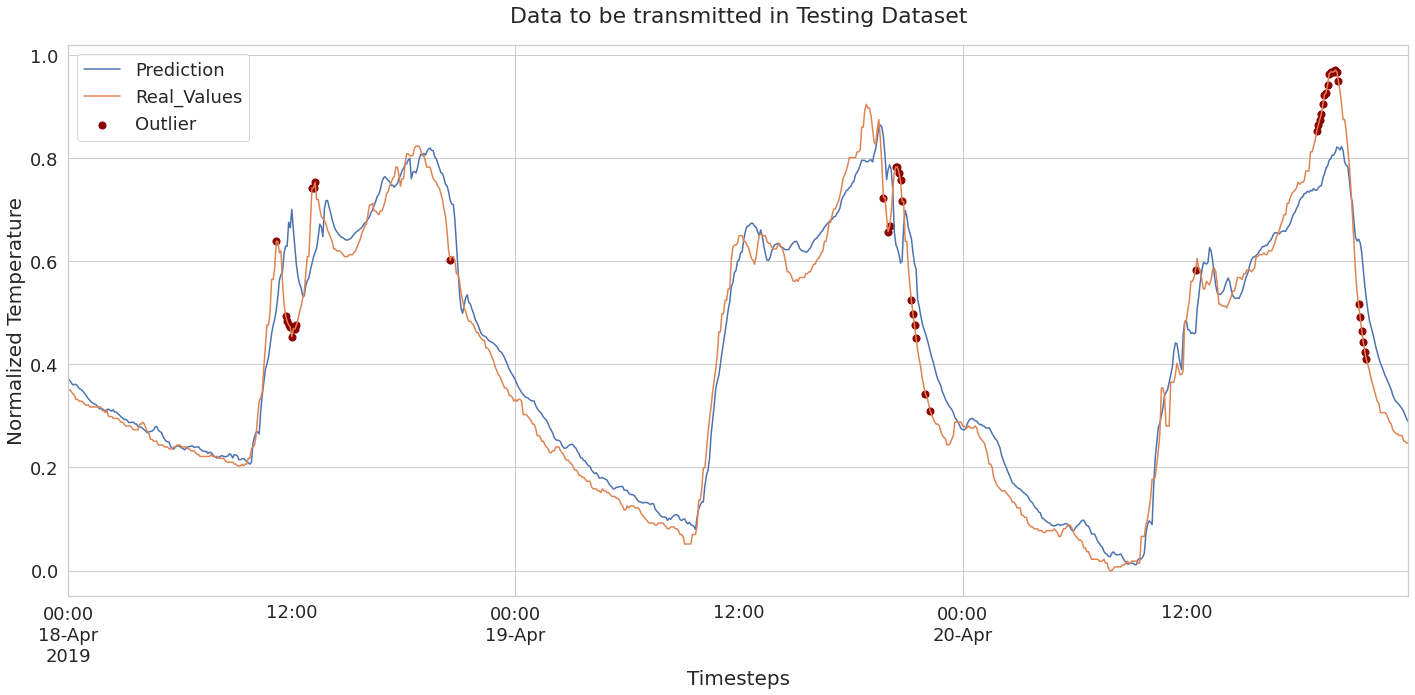

In [ ]:
MAE_df = anomalies(predictions_df, model=model_att, model_label='Attention')

Q3: 0.038
Percent Transmitted = 33.794392523364486 with Attention model and k = 1
Q3: 0.038
Percent Transmitted = 20.93457943925234 with Attention model and k = 1.5
Q3: 0.038
Percent Transmitted = 13.94392523364486 with Attention model and k = 2
Q3: 0.038
Percent Transmitted = 9.345794392523365 with Attention model and k = 2.5
Q3: 0.038
Percent Transmitted = 6.130841121495327 with Attention model and k = 3
Q3: 0.038
Percent Transmitted = 3.588785046728972 with Attention model and k = 3.5


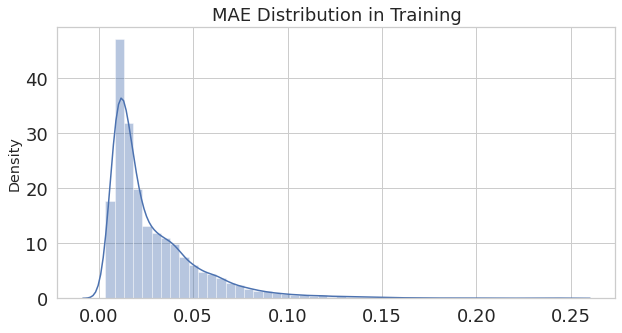

In [ ]:
plt.figure(figsize=(10,5))
plt.title('MAE Distribution in Training')
sns.distplot(a=mae_overall_train)

for k in [1,1.5,2,2.5,3,3.5]:
  _ = anomalies(predictions_df, model=model_att, model_label='Attention', k=k, plot=False)

Data summarization provides a convenient way to describe all of the values in a data sample with just a few statistical values.

The mean and standard deviation are used to summarize data with a Gaussian distribution, but may not be meaningful, or could even be misleading, if your data sample has a non-Gaussian distribution.

The most common example of data summarization is the calculation of the mean and standard deviation for data that has a Gaussian distribution. With these two parameters alone, you can understand and re-create the distribution of the data. The data summary can compress as few as tens or as many as millions individual observations.

The problem is, you cannot easily calculate the mean and standard deviation of data that does not have a Gaussian distribution. Technically, you can calculate these quantities, but they do not summarize the data distribution; in fact, they can be very misleading.

In the case of data that does not have a Gaussian distribution, you can summarize the data sample using the five-number summary.

The five-number summary involves the calculation of 5 summary statistical quantities: namely:

- Median: The middle value in the sample, also called the 50th percentile or the 2nd quartile.
- 1st Quartile: The 25th percentile. 
- 3rd Quartile: The 75th percentile.
- Minimum: The smallest observation in the sample.
- Maximum: The largest observation in the sample.

Not all data is normal or normal enough to treat it as being drawn from a Gaussian distribution. A good statistic for summarizing a non-Gaussian distribution sample of data is the Interquartile Range, or IQR for short. The IQR can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is the value 1.5. A factor k of 3 or more can be used to identify values that are extreme outliers or “far outs” when described in the context of box and whisker plots. On a box and whisker plot, these limits are drawn as fences on the whiskers (or the lines) that are drawn from the box. Values that fall outside of these values are drawn as dots. We can calculate the percentiles of a dataset using the percentile() NumPy function that takes the dataset and specification of the desired percentile. The IQR can then be calculated as the difference between the 75th and 25th percentiles.